In [1]:
import torch
from torch import nn
from torch.utils import data
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from copy import deepcopy
from collections import deque

from extrapolation import *
from experiments import difference_matrix

In [2]:
torch.cuda.is_available()

True

In [3]:
transform = transforms.Compose([
    transforms.Resize((7, 7)),
    transforms.ToTensor()
])
train_ds = datasets.MNIST("../MNIST", download=True, train=True, transform=transform)
test_ds = datasets.MNIST("../MNIST", download=True, train=False, transform=transform)
valid_size = int(0.2 * len(train_ds))
train_ds, valid_ds = data.random_split(train_ds, [len(train_ds) - valid_size, valid_size])

train_loader = data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
valid_loader = data.DataLoader(valid_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(3*3*32, 10),
    nn.LogSoftmax(-1),
)
model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=288, out_features=10, bias=True)
  (4): LogSoftmax(dim=-1)
)

In [5]:
val_loss_fn = nn.NLLLoss(reduction="sum")

def validation(model, loader):
    ok = 0
    loss_sum = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.cuda()
            y = y.cuda()
            out = model(x)
            loss_sum += val_loss_fn(out, y)
            preds = out.argmax(1)
            ok += (y == preds).sum()
            total += len(y)
    return ok / total, loss_sum / total

def train_epoch(loss_log):
    model.train()
    for x, y in tqdm(train_loader):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        loss_log.append(loss.item())
        optimizer.step()

In [6]:
validation(model, valid_loader)

(tensor(0.0904, device='cuda:0'), tensor(2.3214, device='cuda:0'))

## Without acceleration

In [7]:
initial_state = deepcopy(model.state_dict())
optimizer = torch.optim.SGD(model.parameters(), 3e-3)
loss_fn = nn.NLLLoss()

In [8]:
epochs = 25
without_acc = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(without_acc["train_loss"])
    val_acc, val_loss = validation(model, valid_loader)
    without_acc["val_loss"].append(val_loss)
    without_acc["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.4645, validation loss: 2.2038
Epoch 2



Validation accuracy: 0.6097, validation loss: 2.0621
Epoch 3



Validation accuracy: 0.6574, validation loss: 1.8790
Epoch 4



Validation accuracy: 0.6872, validation loss: 1.6631
Epoch 5



Validation accuracy: 0.7174, validation loss: 1.4448
Epoch 6



Validation accuracy: 0.7417, validation loss: 1.2541
Epoch 7



Validation accuracy: 0.7595, validation loss: 1.1044
Epoch 8



Validation accuracy: 0.7719, validation loss: 0.9918
Epoch 9



Validation accuracy: 0.7846, validation loss: 0.9072
Epoch 10



Validation accuracy: 0.7925, validation loss: 0.8423
Epoch 11



Validation accuracy: 0.8004, validation loss: 0.7921
Epoch 12



Validation accuracy: 0.8048, validation loss: 0.7517
Epoch 13



Validation accuracy: 0.8111, validation loss: 0.7192
Epoch 14



Validation accuracy: 0.8152, validation loss: 0.6919
Epoch 15



Validation accuracy: 0.8185, validation loss: 0.6686
Epoch 16



Validation accuracy: 0.8230, validation loss: 0.6493
Epoch 17



Validation accuracy: 0.8271, validation loss: 0.6322
Epoch 18



Validation accuracy: 0.8304, validation loss: 0.6172
Epoch 19



Validation accuracy: 0.8332, validation loss: 0.6039
Epoch 20



Validation accuracy: 0.8378, validation loss: 0.5918
Epoch 21



Validation accuracy: 0.8401, validation loss: 0.5810
Epoch 22



Validation accuracy: 0.8423, validation loss: 0.5712
Epoch 23



Validation accuracy: 0.8442, validation loss: 0.5621
Epoch 24



Validation accuracy: 0.8464, validation loss: 0.5536
Epoch 25



Validation accuracy: 0.8480, validation loss: 0.5463


In [9]:
final_without_acc = deepcopy(model.state_dict())

## With acceleration, online scheme

In [10]:
def params_to_vector(parameters):
    param_vectors = []
    for param in parameters:
        param_vectors.append(param.data.flatten().cpu())
    return torch.hstack(param_vectors)

def params_from_vector(parameters, x):
    idx = 0
    for param in parameters:
        n = param.data.numel()
        param.data[:] = x[idx:idx+n].view(param.data.shape)
        idx += n

In [11]:
params_to_vector(model.parameters()).shape

torch.Size([3722])

In [19]:
model.load_state_dict(initial_state)
optimizer = torch.optim.SGD(model.parameters(), 3e-3)

In [20]:
epochs = 25
k = 5
with_acc = {"train_loss": [], "val_loss": [], "val_acc": []}
model_hist = deque(maxlen=k+1)

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(with_acc["train_loss"])

    x = params_to_vector(model.parameters())
    model_hist.append(x)
    if len(model_hist) == k + 1:
        U = difference_matrix(list(model_hist))
        y = regularized_RRE(torch.vstack(list(model_hist)[1:]), U, 1e-5)
        params_from_vector(model.parameters(), y)
    
    val_acc, val_loss = validation(model, valid_loader)
    with_acc["val_loss"].append(val_loss)
    with_acc["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.4507, validation loss: 2.2037
Epoch 2



Validation accuracy: 0.6085, validation loss: 2.0620
Epoch 3



Validation accuracy: 0.6538, validation loss: 1.8787
Epoch 4



Validation accuracy: 0.6843, validation loss: 1.6632
Epoch 5



Validation accuracy: 0.7175, validation loss: 1.4444
Epoch 6



Validation accuracy: 0.7521, validation loss: 1.3032
Epoch 7



Validation accuracy: 0.7100, validation loss: 1.5744
Epoch 8



Validation accuracy: 0.7461, validation loss: 1.2844
Epoch 9



Validation accuracy: 0.7704, validation loss: 1.1501
Epoch 10



Validation accuracy: 0.7615, validation loss: 1.2305
Epoch 11



Validation accuracy: 0.7721, validation loss: 1.1128
Epoch 12



Validation accuracy: 0.7779, validation loss: 1.0601
Epoch 13



Validation accuracy: 0.7817, validation loss: 1.0158
Epoch 14



Validation accuracy: 0.7803, validation loss: 1.0296
Epoch 15



Validation accuracy: 0.7881, validation loss: 0.9572
Epoch 16



Validation accuracy: 0.7911, validation loss: 0.9120
Epoch 17



Validation accuracy: 0.7887, validation loss: 0.9372
Epoch 18


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff528d359d0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff528d359d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/miniconda3/envs/torch/lib/python3.8/multiprocessing/process.py", line 147, in join
  File "/opt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)



Validation accuracy: 0.7918, validation loss: 0.9094
Epoch 19


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff528d359d0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff528d359d0>
  File "/opt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
  File "/opt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/opt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/miniconda3/envs/torch/lib/python3.8/multiprocessing/process.py", line 147, in join

  File "/opt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can onl


Validation accuracy: 0.7962, validation loss: 0.8656
Epoch 20



Validation accuracy: 0.7974, validation loss: 0.8460
Epoch 21



Validation accuracy: 0.7962, validation loss: 0.8615
Epoch 22



Validation accuracy: 0.8000, validation loss: 0.8277
Epoch 23



Validation accuracy: 0.8051, validation loss: 0.7875
Epoch 24



Validation accuracy: 0.8045, validation loss: 0.7968
Epoch 25



Validation accuracy: 0.8056, validation loss: 0.7866


## With acceleration, offline scheme

In [21]:
model.load_state_dict(initial_state)
optimizer = torch.optim.SGD(model.parameters(), 3e-3)

In [22]:
epochs = 25
k = 5
with_acc_offline = {"train_loss": [], "val_loss": [], "val_acc": []}
model_hist = deque(maxlen=k)

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(with_acc_offline["train_loss"])
    
    model_acc = None
    x = params_to_vector(model.parameters())
    if len(model_hist) >= k:
        U = difference_matrix(list(model_hist) + [x])
        y = regularized_RRE(torch.vstack(list(model_hist)), U, 1e-5)
        model_acc = deepcopy(model)
        params_from_vector(model_acc.parameters(), y)
    model_hist.append(x)
        
    if model_acc is None:
        val_acc, val_loss = validation(model, valid_loader)
    else:
        val_acc, val_loss = validation(model_acc, valid_loader)
    with_acc_offline["val_loss"].append(val_loss)
    with_acc_offline["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.4512, validation loss: 2.2036
Epoch 2



Validation accuracy: 0.6070, validation loss: 2.0621
Epoch 3



Validation accuracy: 0.6536, validation loss: 1.8787
Epoch 4



Validation accuracy: 0.6812, validation loss: 1.6629
Epoch 5



Validation accuracy: 0.7169, validation loss: 1.4444
Epoch 6



Validation accuracy: 0.7752, validation loss: 1.3336
Epoch 7



Validation accuracy: 0.7791, validation loss: 1.0055
Epoch 8



Validation accuracy: 0.7921, validation loss: 0.8219
Epoch 9



Validation accuracy: 0.8023, validation loss: 0.7170
Epoch 10



Validation accuracy: 0.8104, validation loss: 0.6589
Epoch 11



Validation accuracy: 0.8212, validation loss: 0.6234
Epoch 12



Validation accuracy: 0.8200, validation loss: 0.6235
Epoch 13



Validation accuracy: 0.8256, validation loss: 0.6058
Epoch 14



Validation accuracy: 0.8311, validation loss: 0.5863
Epoch 15



Validation accuracy: 0.8343, validation loss: 0.5743
Epoch 16



Validation accuracy: 0.8365, validation loss: 0.5671
Epoch 17



Validation accuracy: 0.8412, validation loss: 0.5476
Epoch 18



Validation accuracy: 0.8428, validation loss: 0.5367
Epoch 19



Validation accuracy: 0.8457, validation loss: 0.5289
Epoch 20



Validation accuracy: 0.8494, validation loss: 0.5218
Epoch 21



Validation accuracy: 0.8507, validation loss: 0.5125
Epoch 22



Validation accuracy: 0.8509, validation loss: 0.5122
Epoch 23



Validation accuracy: 0.8549, validation loss: 0.4995
Epoch 24



Validation accuracy: 0.8559, validation loss: 0.4965
Epoch 25



Validation accuracy: 0.8577, validation loss: 0.4912


In [23]:
results = {
    "without_acc": without_acc,
    "with_acc_online": with_acc,
    "with_acc_offline": with_acc_offline,
}
torch.save(results, "smaller_nn_results.p")

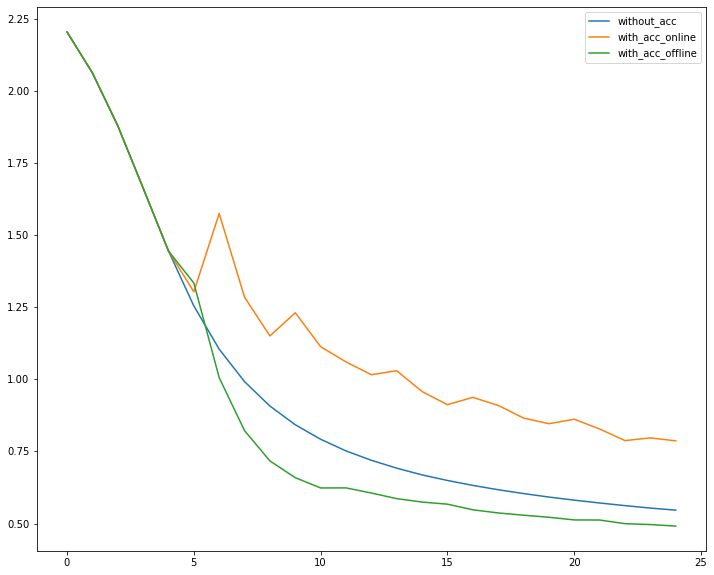

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
x = np.arange(30)
for name, res in results.items():
    plt.plot(x[:25], res["val_loss"][:25], label=name)
plt.legend()